# Treecorr test

In [356]:
from astropy.io import fits
from astropy.cosmology import LambdaCDM
from astropy.constants import c
import numpy as np
import matplotlib.pyplot as plt
import treecorr
from tqdm import tqdm
from perfiles import lenscat_load
#from pandas import DataFrame

## Functions

In [4]:
def make_randoms(ra, dec, z, size_random, col_names=['ra','dec','g1','g2','z']):
    
    print('Making randoms...')

    dec = np.deg2rad(dec)
    sindec_rand = np.random.uniform(np.sin(dec.min()), np.sin(dec.max()), size_random)
    dec_rand = np.arcsin(sindec_rand)*(180/np.pi)
    ra_rand  = np.random.uniform(ra.min(), ra.max(), size_random)

    y,xbins  = np.histogram(z, 25)
    x  = xbins[:-1]+0.5*np.diff(xbins)
    n = 3
    poly = np.polyfit(x,y,n)
    zr = np.random.uniform(z.min(),z.max(),1_000_000)
    poly_y = np.poly1d(poly)(zr)
    poly_y[poly_y<0] = 0.
    peso = poly_y/sum(poly_y)
    z_rand = np.random.choice(zr,size_random,replace=True,p=peso)

    randoms = {col_names[0]: ra_rand, col_names[1]: dec_rand, col_names[-1]:z_rand}
    
    print('Wii randoms!')
    
    return randoms

In [44]:
h = 1.0
cosmo = LambdaCDM(H0=100*h, Om0=0.25, Ode0=0.75)
def compute_xi_2d(positions, random_positions,
                  voids, random_voids,
                  npi = 16, nbins = 12,
                  rmin = 0.1, rmax = 200., pi_max = 60.,
                  NPatches = 16, slop = 0.,
                  cosmo = cosmo, ncores = 4):

    ## Auxiliary functions to compute the covariance
    def func(corrs):
        return corrs[0].weight*0.5
    
    def func2(corrs):
        return corrs[0].weight
    
    """ Compute the galaxy-shape correlation in 3D. """

    # arrays to store the output
    r         = np.zeros(nbins)
    mean_r    = np.zeros(nbins)
    mean_logr = np.zeros(nbins)

    xi    = np.zeros((npi, nbins))
    xi_jk = np.zeros((NPatches, npi, nbins))
    dd_jk = np.zeros_like(xi_jk)
    dr_jk = np.zeros_like(xi_jk)
    rr_jk = np.zeros_like(xi_jk)

    d_p  = cosmo.comoving_distance(positions['z']).value
    d_r = cosmo.comoving_distance(random_positions['z']).value
    d_v = cosmo.comoving_distance(voids['z']).value
    d_v_r = cosmo.comoving_distance(random_voids['z']).value

    print('Loading catalogs...')
    
    pcat = treecorr.Catalog(ra=positions['ra'], dec=positions['dec'],
                             r=d_p, npatch = NPatches,
                             ra_units='deg', dec_units='deg')
    
    vcat = treecorr.Catalog(ra= voids['ra'], dec=voids['dec'],
                             r=d_v, npatch = pcat.patch_centers,
                             ra_units='deg', dec_units='deg')

    rcat = treecorr.Catalog(ra=random_positions['ra'], dec=random_positions['dec'],
                             r=d_r, npatch = NPatches,
                             patch_centers = pcat.patch_centers,
                             ra_units='deg', dec_units='deg')
    
    vran = treecorr.Catalog(ra=random_voids['ra'], dec=random_voids['dec'],
                             r=d_v_r, npatch = NPatches,
                             patch_centers = pcat.patch_centers,
                             ra_units='deg', dec_units='deg')

    Nd = pcat.sumw
    Nr = rcat.sumw
    NNpairs = (Nd*(Nd - 1))/2.
    RRpairs = (Nr*(Nr - 1))/2.
    NRpairs = (Nd*Nr)

    f0 = RRpairs/NNpairs
    f1 = RRpairs/NRpairs

    Pi = np.linspace(-1.*pi_max, pi_max, npi+1)
    pibins = zip(Pi[:-1],Pi[1:])

    # now loop over Pi bins, and compute w(r_p | Pi)
    #bar = progressbar.ProgressBar(maxval=npi-1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    #bar.start()
    print('Calcualting correlation...')
    for p,(plow,phigh) in enumerate(tqdm(pibins)):

        #bar.update(p)
        dd = treecorr.NNCorrelation(nbins=nbins, min_sep=rmin, max_sep=rmax,
                                    min_rpar=plow, max_rpar=phigh,
                                    bin_slop=slop, brute = False, verbose=0, var_method = 'jackknife')
        
        dr = treecorr.NNCorrelation(nbins=nbins, min_sep=rmin, max_sep=rmax,
                                    min_rpar=plow, max_rpar=phigh,
                                    bin_slop=slop, brute = False, verbose=0, var_method = 'jackknife')
        
#         rd = treecorr.NNCorrelation(nbins=nbins, min_sep=rmin, max_sep=rmax,
#                                     min_rpar=plow, max_rpar=phigh,
#                                     bin_slop=slop, brute = False, verbose=0, var_method = 'jackknife')
        
#         rr = treecorr.NNCorrelation(nbins=nbins, min_sep=rmin, max_sep=rmax,
#                                     min_rpar=plow, max_rpar=phigh,
#                                     bin_slop=slop, brute = False, verbose=0, var_method = 'jackknife')

        dd.process(pcat,vcat, metric='Rperp', num_threads = ncores)
        dr.process(rcat,vcat, metric='Rperp', num_threads = ncores)
        # rd.process(rcat,vcat, metric='Rperp', num_threads = ncores)
        # rr.process(rcat,vran, metric='Rperp', num_threads = ncores)

        r[:] = np.copy(dd.rnom)
        mean_r[:] = np.copy(dd.meanr)
        mean_logr[:] = np.copy(dd.meanlogr)

        # xi[p, :] = (dd.weight*f0 - (dr.weight + rd.weight)*f1 + rr.weight) / (rr.weight)
        xi[p, :] = (Nr/Nd) * (dd.weight / dr.weight) - 1.0

        # xi[p,:], _ = dd.calculateXi(rr=rr)
        
        #Here I compute the variance
        dd_jk[:, p, :], weight = treecorr.build_multi_cov_design_matrix([dd], 'jackknife', func = func)
        dr_jk[:, p, :], weight = treecorr.build_multi_cov_design_matrix([dr], 'jackknife', func = func2)
        # rr_jk[:, p, :], weight = treecorr.build_multi_cov_design_matrix([rr], 'jackknife', func = func)

        dd.finalize()
        dr.finalize()
        # rr.finalize()

    for i in range(NPatches):

        swd = np.sum(pcat.w[~(pcat.patch == i)])
        swr = np.sum(rcat.w[~(rcat.patch == i)])

        NNpairs_JK = (swd*(swd - 1))/2.
        RRpairs_JK = (swr*(swr - 1))/2.
        NRpairs_JK = (swd*swr)

        xi_jk[i, :, :] = (dd_jk[i, :, :]/NNpairs_JK - (2.*dr_jk[i, :, :])/NRpairs_JK + rr_jk[i, :, :]/RRpairs_JK) / (rr_jk[i, :, :]/RRpairs_JK)

    xi[np.isinf(xi)] = 0. #It sets to 0 the values of xi_gp that are infinite
    xi[np.isnan(xi)] = 0. #It sets to 0 the values of xi_gp that are null

    xPi=(Pi[:-1]+Pi[1:])/2 #It returns an array going from -9.5,-8.5,...,8.5,9.5

    return r, mean_r, mean_logr, xPi, xi, xi_jk

In [42]:
def compute_wprp(positions, random_positions,
                  voids, random_voids,
                  npi = 16, nbins = 12,
                  rmin = 0.1, rmax = 100., pi_max = 60.,
                  NPatches = 16, slop = 0.,
                  cosmo = cosmo, ncores = 4):
    
    r, mean_r, mean_logr, xPi, xi, xi_jk = compute_xi_2d(positions, random_positions,
                                                         voids, random_voids,
                                                         npi, nbins, rmin, rmax, pi_max,
                                                         NPatches, slop,
                                                         cosmo, ncores)

    wprp = np.trapz(xi,xPi,axis=0)
    wprp_JK = np.trapz(xi_jk,xPi,axis=1)
    wprp_mean = np.mean(wprp_JK, axis = 0)
    wprp_diff = wprp_JK - wprp_mean
    cov_JK = ((NPatches-1)/NPatches)*np.sum(np.einsum('ij,ik->ijk',wprp_diff,wprp_diff), axis = 0)
    sigma = np.sqrt(np.diagonal(cov_JK))
    print('End!')
    
    result = {'rp':r, 'wprp':wprp, 'sigma':sigma, 'cov_JK':cov_JK, 'xPi':xPi, 'xi':xi, 'xi_jk':xi_jk, 'wprp_JK':wprp_JK}
    return result

## Computation CENTRALES

In [48]:
mparticle = 2.93e10 # Msun/h
with fits.open('../../cats/MICE/mice_sats_18939.fits') as f:
    mr_gal = f[1].data.mr_gal
    flag_central = f[1].data.flag_central
    lmhalo = f[1].data.lmhalo
    mask_particles = (lmhalo > np.log10(10*mparticle))
    mask_central = (flag_central == 0)
    mask_mr = (mr_gal < -21) ## igual q satelites, probablemente no sea el corte d completitud
    mask_particles = (lmhalo > np.log10(10*mparticle))
    ra_gal = f[1].data.ra_gal[mask_particles & mask_central & mask_mr]
    dec_gal = f[1].data.dec_gal[mask_particles & mask_central & mask_mr]
    z_gal = f[1].data.z_cgal[mask_particles & mask_central & mask_mr]
    # lmhalo = lmhalo[mask_particles]
del lmhalo, mr_gal, flag_central, mask_particles, mask_central, mask_mr

In [49]:
ang_pos  = {'ra':ra_gal, 'dec':dec_gal, 'z':z_gal}
rand_pos = make_randoms(ra_gal, dec_gal, z_gal, 2*len(ra_gal))
# print(min(ang_pos['z']))

Making randoms...
Wii randoms!


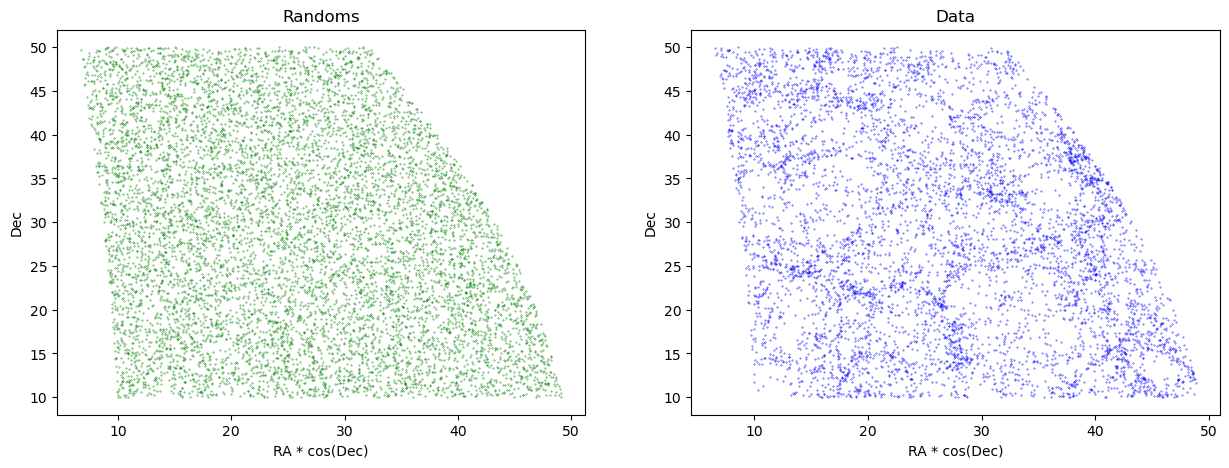

In [52]:
amin, amax = 10,50
alpha = 0.9
maskz = (ang_pos['z'] > 0.1) & (ang_pos['z'] <= 0.15)
maskzr = (rand_pos['z'] > 0.1) & (rand_pos['z'] <= 0.15)
mran = (rand_pos['ra'] > amin) & (rand_pos['ra'] < amax) & (rand_pos['dec'] > amin) & (rand_pos['dec'] < amax)
mtru = (ang_pos['ra'] > amin) & (ang_pos['ra'] < amax) & (ang_pos['dec'] > amin) & (ang_pos['dec'] < amax)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.scatter(rand_pos['ra'][maskzr & mran] * np.cos(rand_pos['dec'][maskzr & mran]*np.pi/180), rand_pos['dec'][maskzr & mran], color='green', s=0.1, alpha=alpha)
ax1.set_xlabel('RA * cos(Dec)')
ax1.set_ylabel('Dec')
# ax1.set_xlim(3,5)
# ax1.set_ylim(83,85)
ax1.set_title('Randoms')

ax2.scatter(ang_pos['ra'][maskz & mtru] * np.cos(ang_pos['dec'][maskz & mtru]*np.pi/180), ang_pos['dec'][maskz & mtru], color='blue', s=0.1, alpha=alpha)
ax2.set_xlabel('RA * cos(Dec)')
ax2.set_ylabel('Dec')
# ax2.set_xlim(5,35)
# ax2.set_ylim(5,35)
ax2.set_title('Data')

plt.show()

In [53]:
centrals = compute_wprp(ang_pos, rand_pos,                  
                       npi = 16, nbins = 12,
                       rmin = 0.5, rmax = 40., pi_max = 40.,
                       NPatches = 16, slop = 0.,
                       cosmo = cosmo, ncores = 128)

Loading catalogs...
Calcualting correlation...


16it [02:05,  7.87s/it]


End!


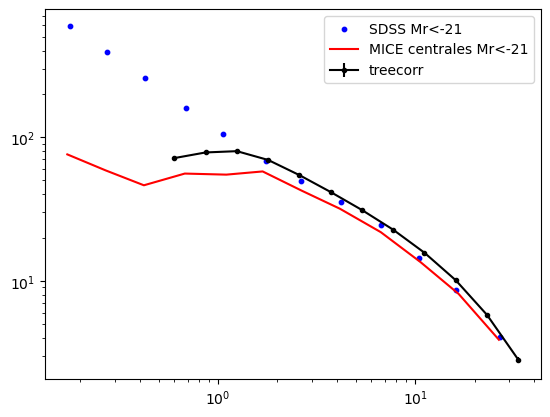

In [55]:
plt.errorbar(centrals['rp'], centrals['wprp'], centrals['sigma'],fmt='k.-', label='treecorr')
plt.scatter(xSDSS,ySDSS, s=10.0, c='b', label='SDSS Mr<-21')
plt.plot(xmice_c,ymice_c, c='r', label='MICE centrales Mr<-21')
# plt.xlim(-0.5,35)
# plt.ylim(0.1, 20_000)
plt.loglog()
# plt.axvline(10, ls='--',c='k',alpha=0.2)
# plt.axhline(wprp[8], ls='--',c='k',alpha=0.2)
# plt.text(1,wprp[8]+1,f'{wprp[8]:.2e}')
plt.legend()
plt.show()

Text(0, 0.5, '$\\pi$')

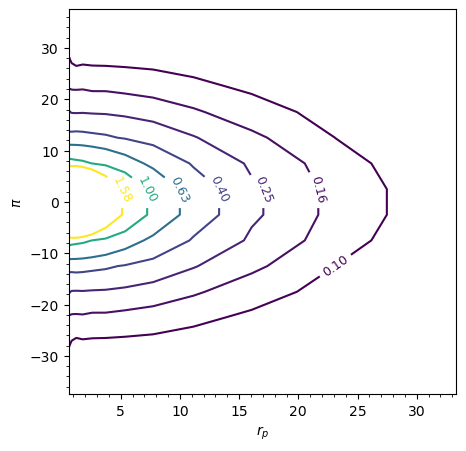

In [56]:
X, Y = np.meshgrid(centrals['rp'], centrals['xPi'])
levels = np.array([0.1,0.16,0.25,0.4,0.63,1.0,1.58])
fig, ax = plt.subplots(figsize=(5,5))
# plt.ylim(0,20)
# plt.xlim(0,20)
CS = ax.contour(X, Y, centrals['xi'],
                levels=levels)
ax.clabel(CS, inline=True, fontsize=9)
plt.minorticks_on()
plt.xlabel('$r_p$')
plt.ylabel('$\\pi$')
# plt.colorbar(CS)

## Computation SATELITES

In [57]:
mparticle = 2.93e10 # Msun/h
with fits.open('../../cats/MICE/mice_sats_18939.fits') as f:
    mr_gal = f[1].data.mr_gal
    flag_central = f[1].data.flag_central
    lmhalo = f[1].data.lmhalo
    mask_particles = (lmhalo > np.log10(10*mparticle))
    mask_central = (flag_central == 1)
    mask_mr = (mr_gal < -21) ## la moda
    ra_gal = f[1].data.ra_gal[mask_particles & mask_central & mask_mr]
    dec_gal = f[1].data.dec_gal[mask_particles & mask_central & mask_mr]
    z_gal = f[1].data.z_cgal[mask_particles & mask_central & mask_mr]
    # lmhalo = lmhalo[mask_particles]
del lmhalo, mr_gal, mask_particles, mask_central, mask_mr

In [58]:
## correction for ra >= 0
dec_gal = dec_gal[ra_gal>=0]
z_gal = z_gal[ra_gal>=0]
ra_gal = ra_gal[ra_gal>=0]

In [59]:
ang_pos  = {'ra':ra_gal, 'dec':dec_gal, 'z':z_gal}
rand_pos = make_randoms(ra_gal, dec_gal, z_gal, 2*len(ra_gal))
# print(min(ang_pos['z']))

Making randoms...
Wii randoms!


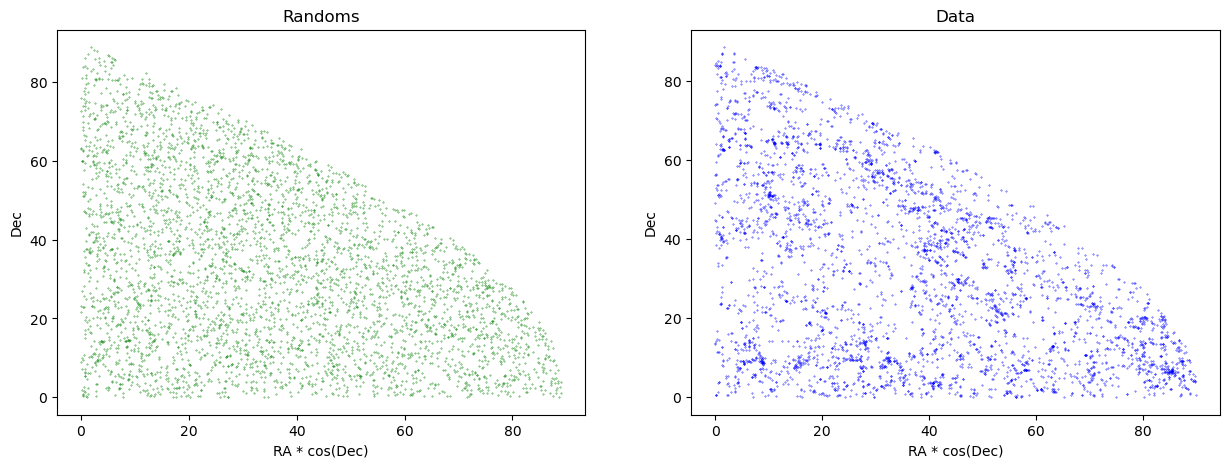

In [61]:
amin, amax = 0,90
alpha = 0.9
maskz = (ang_pos['z'] > 0.1) & (ang_pos['z'] <= 0.13)
maskzr = (rand_pos['z'] > 0.1) & (rand_pos['z'] <= 0.13)
mran = (rand_pos['ra'] > amin) & (rand_pos['ra'] < amax) & (rand_pos['dec'] > amin) & (rand_pos['dec'] < amax)
mtru = (ang_pos['ra'] > amin) & (ang_pos['ra'] < amax) & (ang_pos['dec'] > amin) & (ang_pos['dec'] < amax)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.scatter(rand_pos['ra'][maskzr & mran] * np.cos(rand_pos['dec'][maskzr & mran]*np.pi/180), rand_pos['dec'][maskzr & mran], color='green', s=0.1, alpha=alpha)
ax1.set_xlabel('RA * cos(Dec)')
ax1.set_ylabel('Dec')
# ax1.set_xlim(3,5)
# ax1.set_ylim(83,85)
ax1.set_title('Randoms')

ax2.scatter(ang_pos['ra'][maskz & mtru] * np.cos(ang_pos['dec'][maskz & mtru]*np.pi/180), ang_pos['dec'][maskz & mtru], color='blue', s=0.1, alpha=alpha)
ax2.set_xlabel('RA * cos(Dec)')
ax2.set_ylabel('Dec')
# ax2.set_xlim(5,35)
# ax2.set_ylim(5,35)
ax2.set_title('Data')

plt.show()

In [62]:
sats =  compute_wprp(ang_pos, rand_pos,                  
                     npi = 16, nbins = 12,
                     rmin = 0.5, rmax = 40., pi_max = 40.,
                     NPatches = 16, slop = 0.,
                     cosmo = cosmo, ncores = 128)

Loading catalogs...
Calcualting correlation...


16it [00:30,  1.93s/it]


End!


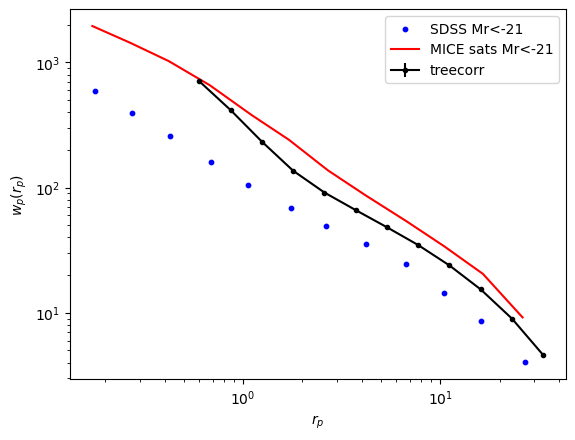

In [78]:
plt.errorbar(sats['rp'], sats['wprp'], sats['sigma'],fmt='k.-',label='treecorr')
plt.scatter(xSDSS,ySDSS, s=10.0, c='b', label='SDSS Mr<-21')
plt.plot(xmice_s,ymice_s, c='r', label='MICE sats Mr<-21')
# plt.xlim(-0.5,35)
# plt.ylim(0.1, 20_000)
plt.loglog()
# plt.axvline(10, ls='--',c='k',alpha=0.2)
# plt.axhline(wprp[8], ls='--',c='k',alpha=0.2)
# plt.text(1,wprp[8]+1,f'{wprp[8]:.2e}')
plt.xlabel('$r_p$')
plt.ylabel('$w_p(r_p)$')
plt.legend()
plt.show()

Text(0, 0.5, '$\\pi$')

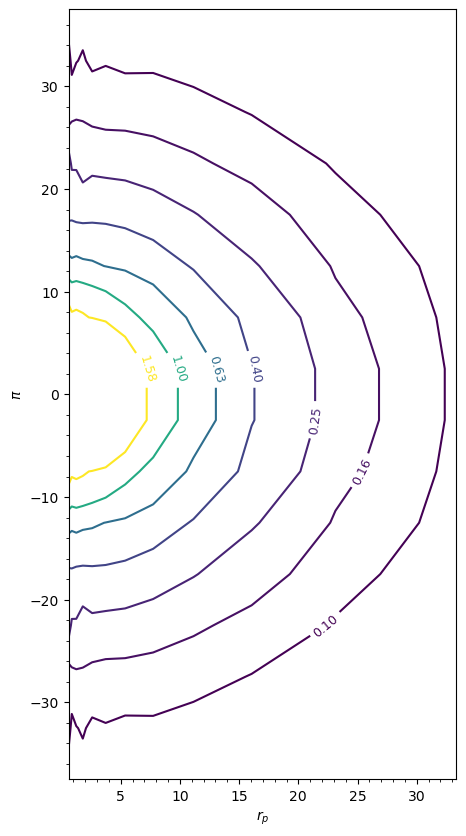

In [94]:
X, Y = np.meshgrid(sats['rp'], sats['xPi'])
levels = np.array([0.1,0.16,0.25,0.4,0.63,1.0,1.58])
fig, ax = plt.subplots(figsize=(5,10))
# plt.ylim(0,20)
# plt.xlim(0,20)
CS = ax.contour(X, Y, sats['xi'],
                levels=levels)
ax.clabel(CS, inline=True, fontsize=9)
plt.minorticks_on()
plt.xlabel('$r_p$')
plt.ylabel('$\\pi$')
# plt.colorbar(CS)

## Zehavi 2011 data

In [227]:
import pandas as pd
path_corr = '../zehavi2011/'
sdss_zehavi_mr_bin_filename = 'Zehavi10_Table_C7_projected_CF_of_magnitude_bins_samples.csv'
sdss_zehavi_mr_bin_blue_filename = 'Zehavi10_Table_C9_projected_CF_of_blue_galaxy_samples_corresponding_to_magnitude_bins.csv'
sdss_zehavi_mr_bin_red_filename  = 'Zehavi10_Table_C10_projected_CF_of_red_galaxy_samples_corresponding_to_magnitude_bins.csv'

sdss_zehavi_mr_bin = pd.read_csv(path_corr+sdss_zehavi_mr_bin_filename)
sdss_zehavi_mr_bin_red = pd.read_csv(path_corr+sdss_zehavi_mr_bin_red_filename)
sdss_zehavi_mr_bin_blue = pd.read_csv(path_corr+sdss_zehavi_mr_bin_blue_filename)
sdss_zehavi_mr_bin_names = ['23_22', '22_21','21_20','20_19','19_18','18_17']
sdss_zehavi_color_names = ['blue', 'red']
bines_zehavi = np.loadtxt(path_corr+'/bins_corr_zehavi')

In [229]:
pd.DataFrame(bines_zehavi, columns=['Mrmin', 'Mrmax', 'zmin', 'zmax'])

,Mrmin,Mrmax,zmin,zmax
0,-23.0,-22.0,0.103000,0.245000
1,-22.0,-21.0,0.066333,0.158833
2,-21.0,-20.0,0.042000,0.106333
3,-20.0,-19.0,0.026833,0.064167
4,-19.0,-18.0,0.017333,0.041667
5,-18.0,-17.0,0.010667,0.026167


[]

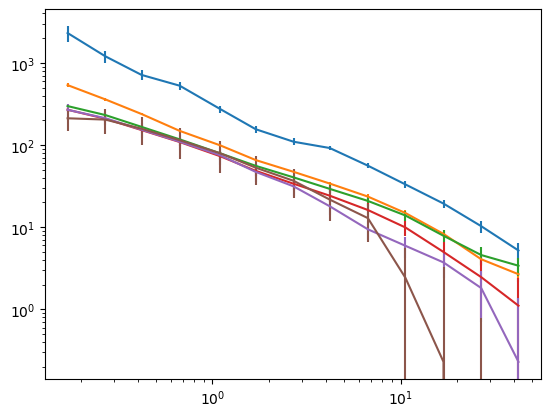

In [211]:
plt.errorbar(sdss_zehavi_mr_bin['rp'],
            sdss_zehavi_mr_bin['23_22'],
            sdss_zehavi_mr_bin['23_22_error'])
plt.errorbar(sdss_zehavi_mr_bin['rp'],
            sdss_zehavi_mr_bin['22_21'],
            sdss_zehavi_mr_bin['22_21_error'])
plt.errorbar(sdss_zehavi_mr_bin['rp'],
            sdss_zehavi_mr_bin['21_20'],
            sdss_zehavi_mr_bin['21_20_error'])
plt.errorbar(sdss_zehavi_mr_bin['rp'],
            sdss_zehavi_mr_bin['20_19'],
            sdss_zehavi_mr_bin['20_19_error'])
plt.errorbar(sdss_zehavi_mr_bin['rp'],
            sdss_zehavi_mr_bin['19_18'],
            sdss_zehavi_mr_bin['19_18_error'])
plt.errorbar(sdss_zehavi_mr_bin['rp'],
            sdss_zehavi_mr_bin['18_17'],
            sdss_zehavi_mr_bin['18_17_error'])
plt.loglog()

## Computation TOTAL

In [95]:
zmin, zmax = 0.02, 47650/c.to('km/s').value
print(zmax)

0.15894329136191945


In [ ]:
mparticle = 2.93e10 # Msun/h
with fits.open('../../cats/MICE/mice_sats_18939.fits') as f:
    z_gal   = f[1].data.z_cgal
    mr_gal  = f[1].data.mr_gal - 0.8 * (np.atan(1.5 * z_gal) - 0.1489) ### Corrección por evolución
    ra_gal  = f[1].data.ra_gal
    dec_gal = f[1].data.dec_gal
    lmhalo = f[1].data.lmhalo
    
# mask_particles = (lmhalo > np.log10(10*mparticle))
# mask_mr = (mr_gal < -21)
# mask_z = (z_gal >= zmin) & (z_gal < zmax)

# ra_gal = ra_gal[mask_particles & mask_mr & mask_z]
# dec_gal = dec_gal[mask_particles & mask_mr & mask_z]
# z_gal = z_gal[mask_particles & mask_mr & mask_z]

# del lmhalo, mr_gal, mask_particles, mask_mr, mask_z

In [244]:
def masked_data(mr0, mr1, z0, z1):
    global ra_gal, dec_gal, z_gal, mr_gal
    m_mr = (mr_gal < mr1) & (mr_gal >= mr0) 
    m_z = (z_gal < z1) & (z_gal >= z0)
    return {'ra':ra_gal[m_mr & m_z], 'dec':dec_gal[m_mr & m_z], 'z':z_gal[m_mr & m_z]}

In [273]:
data_zehavicuts = np.array([masked_data(*bines_zehavi[i]) for i in range(3)])

In [280]:
randoms_zehavicuts = np.array([
    make_randoms(
        data_zehavicuts[i]['ra'],
        data_zehavicuts[i]['dec'],
        data_zehavicuts[i]['z'],
        10*len(data_zehavicuts[i]['ra'])
    ) for i in range(3)
])

Making randoms...
Wii randoms!
Making randoms...
Wii randoms!
Making randoms...
Wii randoms!


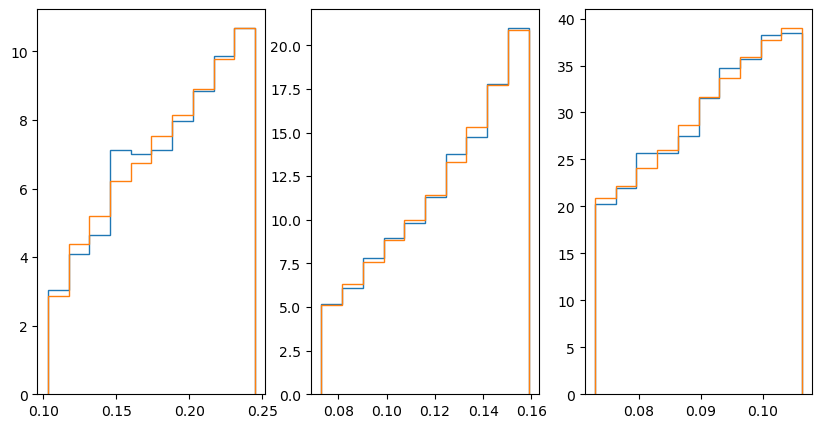

In [283]:
fig, axes = plt.subplots(1,3, figsize=(10,5))
for j,ax in enumerate(axes.flat):
    ax.hist(data_zehavicuts[j]['z'], histtype='step', density=True)
    ax.hist(randoms_zehavicuts[j]['z'], histtype='step', density=True)

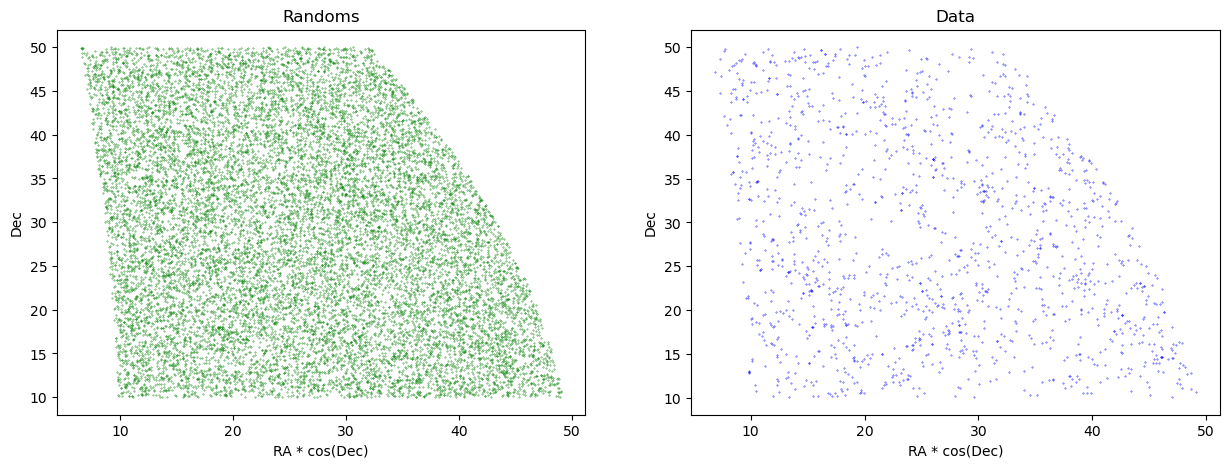

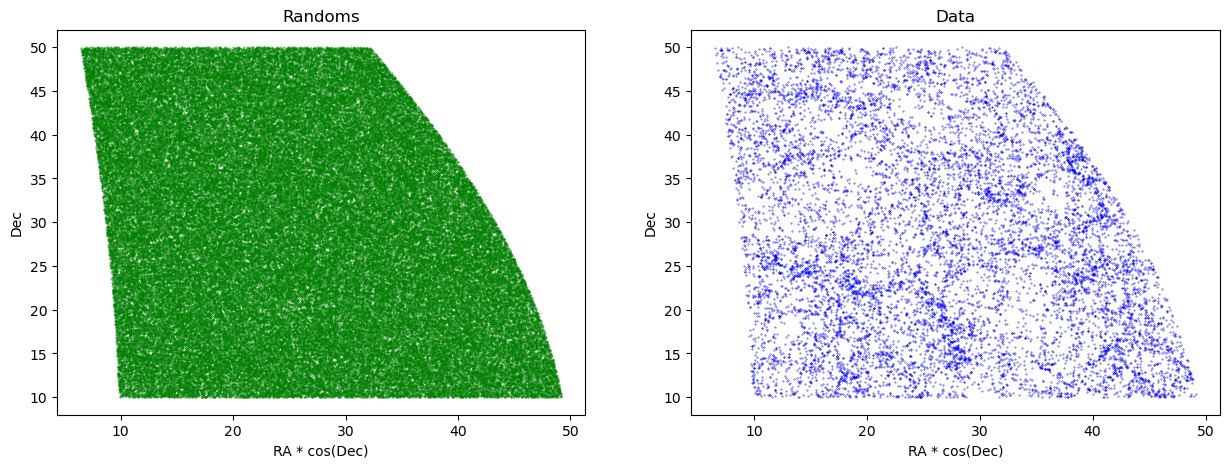

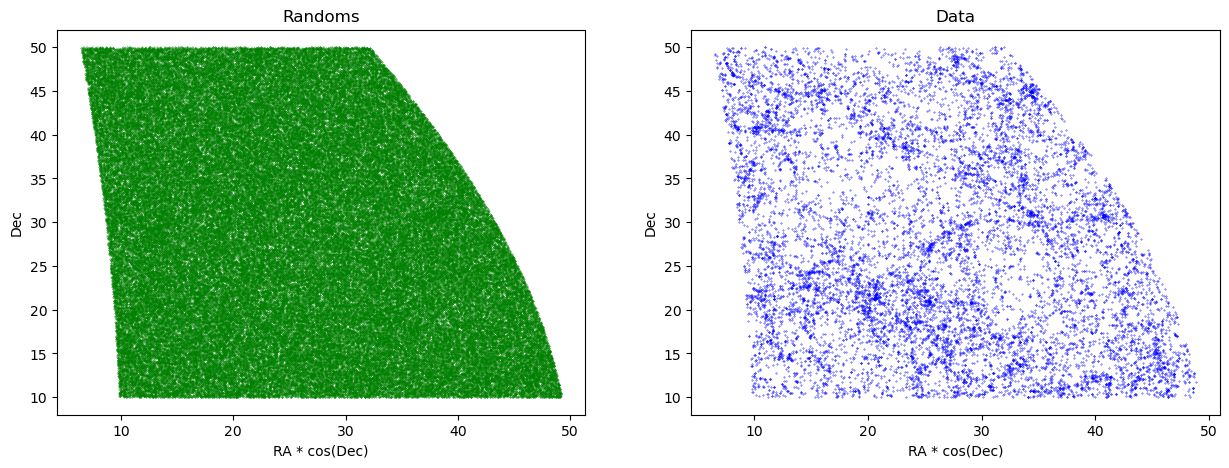

In [284]:
amin, amax = 10,50
alpha = 0.9
# fig, axes = plt.subplots(3,2, figsize(30,10))
for ang_pos, rand_pos in zip(data_zehavicuts, randoms_zehavicuts):
    mran = (rand_pos['ra'] > amin) & (rand_pos['ra'] < amax) & (rand_pos['dec'] > amin) & (rand_pos['dec'] < amax)
    mtru = (ang_pos['ra'] > amin) & (ang_pos['ra'] < amax) & (ang_pos['dec'] > amin) & (ang_pos['dec'] < amax)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    ax1.scatter(rand_pos['ra'][mran] * np.cos(rand_pos['dec'][mran]*np.pi/180), rand_pos['dec'][mran], color='green', s=0.1, alpha=alpha)
    ax1.set_xlabel('RA * cos(Dec)')
    ax1.set_ylabel('Dec')
    # ax1.set_xlim(3,5)
    # ax1.set_ylim(83,85)
    ax1.set_title('Randoms')

    ax2.scatter(ang_pos['ra'][mtru] * np.cos(ang_pos['dec'][mtru]*np.pi/180), ang_pos['dec'][mtru], color='blue', s=0.1, alpha=alpha)
    ax2.set_xlabel('RA * cos(Dec)')
    ax2.set_ylabel('Dec')
    # ax2.set_xlim(5,35)
    # ax2.set_ylim(5,35)
    ax2.set_title('Data')

plt.show()

In [357]:
cf_totals_zehavicuts = []
for ang_pos, rand_pos in zip(data_zehavicuts, randoms_zehavicuts):
    cf_totals_zehavicuts.append(
        compute_wprp(ang_pos, rand_pos,                  
                     npi = 16, nbins = 13,
                     rmin = 0.15, rmax = 50., pi_max = 60.,
                     NPatches = 16, slop = 0.,
                     cosmo = cosmo, ncores = 20)
    )

Loading catalogs...
Calcualting correlation...


16it [00:18,  1.17s/it]


End!
Loading catalogs...
Calcualting correlation...


16it [01:46,  6.65s/it]


End!
Loading catalogs...
Calcualting correlation...


16it [03:56, 14.77s/it]

End!


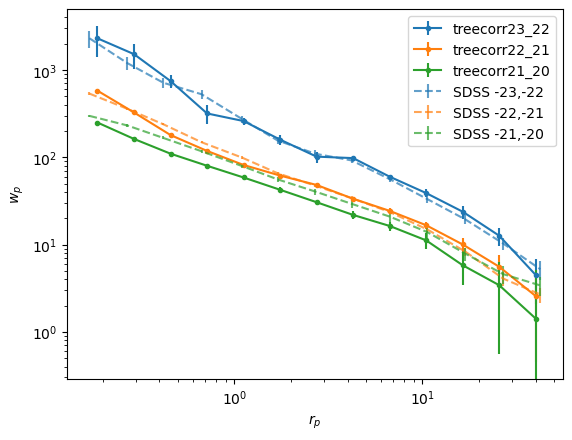

In [359]:
for i in range(3):
    plt.errorbar(cf_totals_zehavicuts[i]['rp'],
                 cf_totals_zehavicuts[i]['wprp'],
                 cf_totals_zehavicuts[i]['sigma'],
                 fmt='.-', label='treecorr'+sdss_zehavi_mr_bin_names[i])
plt.errorbar(sdss_zehavi_mr_bin['rp'],
            sdss_zehavi_mr_bin['23_22'],
            sdss_zehavi_mr_bin['23_22_error'],
            fmt='C0--', alpha=0.7, label='SDSS -23,-22')
plt.errorbar(sdss_zehavi_mr_bin['rp'],
            sdss_zehavi_mr_bin['22_21'],
            sdss_zehavi_mr_bin['22_21_error'],
            fmt='C1--', alpha=0.7, label='SDSS -22,-21')                 
plt.errorbar(sdss_zehavi_mr_bin['rp'],
            sdss_zehavi_mr_bin['21_20'],
            sdss_zehavi_mr_bin['21_20_error'],
            fmt='C2--', alpha=0.7, label='SDSS -21,-20')

# plt.errorbar(xSDSS, ySDSS, erSDSS, c='b', label='SDSS M<-21')
# plt.plot(xmice, ymice, c='r', label='MICE centrales Mr<-21')
# plt.xlim(-0.5,35)
# plt.ylim(0.1, 20_000)
plt.loglog()
# plt.axvline(10, ls='--',c='k',alpha=0.2)
# plt.axhline(wprp[8], ls='--',c='k',alpha=0.2)
# plt.text(1,wprp[8]+1,f'{wprp[8]:.2e}')
plt.xlabel('$r_p$')
plt.ylabel('$w_p$')
plt.legend()
plt.show()

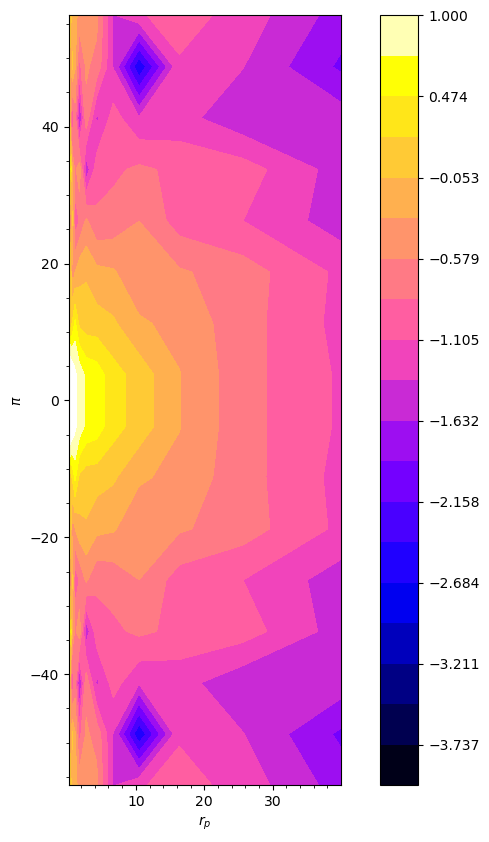

In [361]:
i = 0
X, Y = np.meshgrid(cf_totals_zehavicuts[i]['rp'], cf_totals_zehavicuts[i]['xPi'])
# levels = np.array([0.05,0.1,0.16,0.25,0.4,0.63,1.0,1.58,])
levels = np.linspace(-4, 1, 20)
fig, ax = plt.subplots(figsize=(10,10))
# plt.ylim(0,35)
# plt.xlim(0,35)
CS = ax.contourf(X,Y, np.log10(np.abs(cf_totals_zehavicuts[i]['xi'])),
                levels=levels, cmap='gnuplot2',
                )
# ax.clabel(CS, inline=True, fontsize=9)
ax.set_aspect('equal')
plt.minorticks_on()
plt.xlabel('$r_p$')
plt.ylabel('$\\pi$')
plt.colorbar(CS)

# Treecorr para voids

In [58]:
from astropy.io import fits
from astropy.cosmology import LambdaCDM
from astropy.constants import c
import numpy as np
import matplotlib.pyplot as plt
import treecorr
from tqdm import tqdm
import sys
sys.path.append('../profiles/')
from perfiles import lenscat_load

In [59]:
# from pandas import DataFrame

In [60]:
from vgcf import *
from plots_vgcf import *

Estimador de https://arxiv.org/pdf/2410.19713 (ec 28), en redshift space

$$
    \xi^{s}(s_{\perp}, s_{\|}) = \frac{D_v D_g - D_v R_g - R_v D_g + R_v R_g}{R_v R_g}
$$

Versión light https://arxiv.org/pdf/1705.05328 (ec 4.3) (?????????)

$$
    \xi_{\ell} (r) = D_v D_g - D_v R_g
$$

Version David & Peebles
$$
    \xi = \frac{D_v D_g}{D_v R_g} - 1
$$

In [61]:
h = 1.0
cosmo = LambdaCDM(H0=100*h, Om0=0.25, Ode0=0.75)    

In [62]:
z0,z1 = 0.0, 1.4

with fits.open('/home/fcaporaso/cats/MICE/mice_sats_18939.fits') as f:
    #central = f[1].data.flag_central == 0
    z_gal = f[1].data.z_cgal
    mr_gal  = f[1].data.mr_gal - 0.8 * (np.arctan(1.5 * z_gal) - 0.1489) ### Corrección por evolución
    ra  = f[1].data.ra_gal
    dec = f[1].data.dec_gal
    
m_z = (z_gal < z1) & (z_gal >= z0)
m_mr = (mr_gal <= -21)
ra  = ra[m_z & m_mr]
dec = dec[m_z & m_mr]
z_gal = z_gal[m_z & m_mr]

In [63]:
n_gx = len(z_gal)
print(n_gx)

42551787


In [64]:
gx_true = {'ra':ra, 'dec':dec, 'z':z_gal}
gx_rand = make_randoms(gx_true,size_random=2*n_gx)

Making randoms...
Wii randoms!


In [65]:
# gx_xyz   = ang2xyz(*gx_true.values())
# rand_xyz = ang2xyz(*gx_rand.values())

In [77]:
lens_args = (9.622, 50, 0.2, 0.4, -1.0, -0.8, 0.0, 100.0)
L,_,nvoids = lenscat_load(*lens_args)

In [78]:
print(nvoids)

6391


In [79]:
void_true = {'ra':L[2], 'dec':L[3], 'z':L[4], 'rv':L[1]}
rv_mean = np.mean(void_true['rv'])
# void_rand = make_randoms(void_true, size_random=10*nvoids)

In [80]:
# void_xyz = ang2xyz(void_true['ra'],void_true['dec'],void_true['z'])
# void_rand_xyz = ang2xyz(void_rand['ra'],void_rand['dec'], void_rand['z'])

In [81]:
d_gx  = cosmo.comoving_distance(gx_true['z']).value
d_ran = cosmo.comoving_distance(gx_rand['z']).value
d_vd  = cosmo.comoving_distance(void_true['z']).value
# d_vd_ran = cosmo.comoving_distance(void_rand['z']).value

In [82]:
gx_cat = treecorr.Catalog(ra = gx_true['ra'], dec = gx_true['dec'], r = d_gx,
                          ra_units='deg', dec_units='deg')
gx_ran = treecorr.Catalog(ra = gx_rand['ra'], dec = gx_rand['dec'], r = d_ran,
                          ra_units='deg', dec_units='deg')
vd_cat = treecorr.Catalog(ra = void_true['ra'], dec = void_true['dec'], r = d_vd,
                          ra_units='deg', dec_units='deg')
# vd_ran = treecorr.Catalog(ra = void_rand['ra'], dec = void_rand['dec'], r = d_vd_ran,
#                           ra_units='deg', dec_units='deg')

In [83]:
ncores = 120
metric = 'Rperp'
pi_max = 5*rv_mean
npi = 50
nbins = 50

r = np.zeros(nbins)
mean_r = np.zeros(nbins)
xi = np.zeros((npi, nbins))

Pi = np.linspace(-1.*pi_max, pi_max, npi+1)
xPi = (Pi[:-1]+Pi[1:])/2
pibins = zip(Pi[:-1],Pi[1:])

print('Calcualting correlation...')
for p,(plow,phigh) in enumerate(tqdm(pibins)):

    dd = treecorr.NNCorrelation(min_sep=0.01*rv_mean, max_sep=5.0*rv_mean, min_rpar=plow, max_rpar=phigh,
                                nbins=nbins, bin_type='Linear', brute=False, bin_slop=0, metric=metric, num_threads=ncores)
    dr = treecorr.NNCorrelation(min_sep=0.01*rv_mean, max_sep=5.0*rv_mean, min_rpar=plow, max_rpar=phigh,
                                nbins=nbins, bin_type='Linear', brute=False, bin_slop=0, metric=metric, num_threads=ncores)
    # rd = treecorr.NNCorrelation(min_sep=0.05, max_sep=50., nbins=50, bin_type='Linear', brute=False, bin_slop=0, metric=metric, num_threads=ncores)
    # rr = treecorr.NNCorrelation(min_sep=0.05, max_sep=50., nbins=50, bin_type='Linear', brute=False, bin_slop=0, metric=metric, num_threads=ncores)
    
    dd.process(vd_cat, gx_cat)
    dr.process(vd_cat, gx_ran)
    # rd.process(vd_ran, gx_cat)
    # rr.process(vd_ran, gx_ran)
    
    r[:] = np.copy(dd.rnom)
    mean_r[:] = np.copy(dd.meanr)
    
    ## para q use davis & peebles: DvDg/DvRg - 1
    xi[p,:], _ = dd.calculateXi(rr=dr)

Calcualting correlation...


50it [02:53,  3.47s/it]


In [84]:
np.min(xi)

-1.0

12.034194226255673


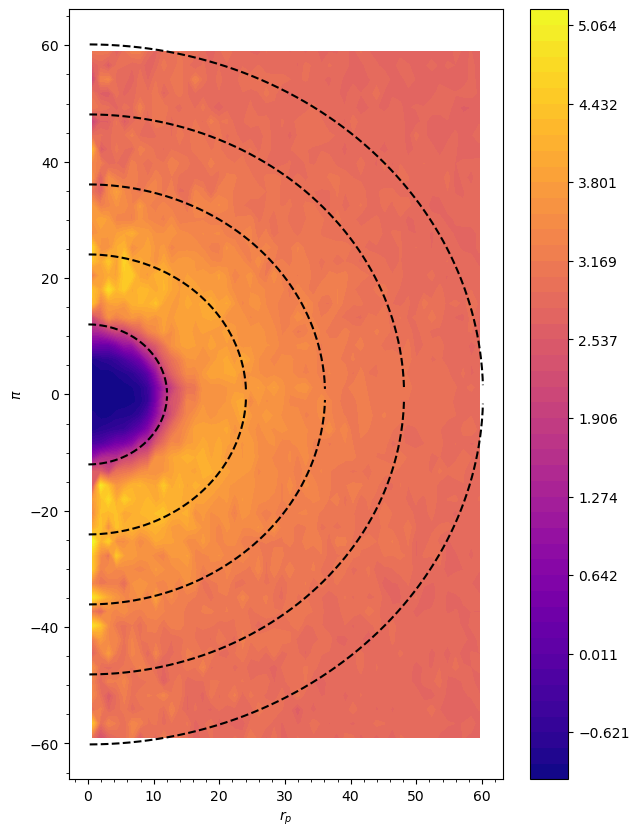

In [85]:
X, Y = np.meshgrid(r, xPi)
levels = np.linspace(np.min(xi), np.max(xi), 50)
fig, ax = plt.subplots(figsize=(7,10))
# plt.ylim(0,20)
# plt.xlim(0,20)
CS = ax.contourf(X, Y, xi,
                cmap='plasma',
                levels=levels)
# ax.clabel(CS, inline=True, fontsize=9)
plt.minorticks_on()
plt.xlabel('$r_p$')
plt.ylabel('$\\pi$')
plt.colorbar(CS)

print(rv_mean)
xx = np.arange(0.05,rv_mean,0.01)
## 1rv
plt.plot(xx, np.sqrt(rv_mean**2 - xx**2), c='k', ls='--')
plt.plot(xx, -np.sqrt(rv_mean**2 - xx**2), c='k', ls='--')
## 2rv
plt.plot(2*xx, np.sqrt((2*rv_mean)**2 - (2*xx)**2), c='k', ls='--')
plt.plot(2*xx, -np.sqrt((2*rv_mean)**2 - (2*xx)**2), c='k', ls='--')
## 3rv
plt.plot(3*xx, np.sqrt((3*rv_mean)**2 - (3*xx)**2), c='k', ls='--')
plt.plot(3*xx, -np.sqrt((3*rv_mean)**2 - (3*xx)**2), c='k', ls='--')
## 4rv
plt.plot(4*xx, np.sqrt((4*rv_mean)**2 - (4*xx)**2), c='k', ls='--')
plt.plot(4*xx, -np.sqrt((4*rv_mean)**2 - (4*xx)**2), c='k', ls='--')
## 5rv
plt.plot(5*xx, np.sqrt((5*rv_mean)**2 - (5*xx)**2), c='k', ls='--')
plt.plot(5*xx, -np.sqrt((5*rv_mean)**2 - (5*xx)**2), c='k', ls='--')

In [86]:
plt.figure(figsize=(10,7))
plt.errorbar(r, xi, varxi, fmt='.-')
# plt.plot(r, xi)
plt.axhline(0, ls='--', c='gray')
plt.axvline(np.mean(void_true['rv']), ls=':', c='b')
plt.xlabel('s [Mpc/h]')
plt.ylabel('$\\xi$ [alguna unidad...]')
# plt.title('$R_v \\in [6,9) \\mathrm{Mpc}/h, \\ z \\in [0.2,0.4),$ tipo S')
# plt.legend()
plt.show()

NameError: name 'varxi' is not defined

<Figure size 1000x700 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,7))
plt.errorbar(r, xi_S_centrales['xi'], xi_S_centrales['varxi'], fmt='.-', label='S')
plt.axhline(0, ls='--', c='gray')
plt.axvline(np.mean(void_true['rv']), ls=':', c='b')
plt.xlabel('s [Mpc/h]')
plt.ylabel('$\\xi$ [alguna unidad...]')
plt.title('$R_v \\in [6,9) \\mathrm{Mpc}/h, \\ z \\in [0.2,0.4),$ tipo S')
plt.legend()
plt.show()

In [ ]:
def vgcf():
    pass